Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..15227684.022801904].


[[4.24020981e+01 4.18681814e+01 4.22804179e+01]
 [4.36042813e+01 4.01269012e+01 4.33541388e+01]
 [4.61088211e+01 3.72908202e+01 4.57262578e+01]
 [4.99179554e+01 3.33743795e+01 4.94017939e+01]
 [5.50338882e+01 2.83918035e+01 5.43856907e+01]
 [6.14587906e+01 2.23571037e+01 6.06828176e+01]
 [6.91948011e+01 1.52840815e+01 6.82979711e+01]
 [7.82440264e+01 7.18633109e+00 7.72358759e+01]
 [8.86085412e+01 0.00000000e+00 8.75011857e+01]
 [1.00290389e+02 0.00000000e+00 9.90984846e+01]
 [1.13276564e+02 0.00000000e+00 1.11998600e+02]
 [1.27561357e+02 0.00000000e+00 1.26188727e+02]
 [1.43144766e+02 0.00000000e+00 1.41668865e+02]
 [1.60026794e+02 0.00000000e+00 1.58439015e+02]
 [1.78207438e+02 0.00000000e+00 1.76499177e+02]
 [1.97686701e+02 0.00000000e+00 1.95849350e+02]
 [2.18464580e+02 0.00000000e+00 2.16489535e+02]
 [2.40541078e+02 0.00000000e+00 2.38419731e+02]
 [2.63916192e+02 0.00000000e+00 2.61639939e+02]
 [2.88589924e+02 0.00000000e+00 2.86150158e+02]
 [3.14562274e+02 0.00000000e+00 3.119503

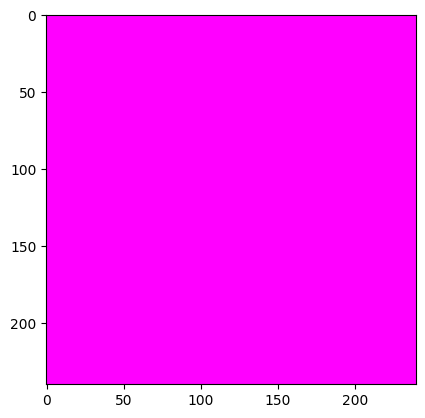

In [ ]:
import grn
import numpy as np
import matplotlib.pyplot as plt


g = grn.GRN()
nin = 2
nout = 3

g.random(nin=nin, nout=nout, nreg=1)

N = 240


matrix = np.zeros((N,N,3))

for i in range(N):
    for j in range(N):
        g.set_input([i/N, j/N])
        g.step()   
        out = g.get_output() * 255
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(matrix[0])
plt.imshow(matrix)
plt.savefig("test.png")